In [1]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from PIL import Image 
import pandas as pd 


In [2]:
train_path = "/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/train"
test_path = "/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/test"

In [3]:
img_width = 64
img_len = 64

In [4]:
train_transforms = transforms.Compose(transforms=[
    transforms.Resize((img_width, img_len)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose(transforms=[
    transforms.Resize((img_width, img_len)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [5]:
from pathlib import Path
import os

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dir_path, transform= None):
        self.dir_path = Path(dir_path)
        self.transform = transform
        self.classes = sorted(os.listdir(dir_path))
        self.img_path = []
        self.img_labels = []
        self.class_names = sorted([d.name for d in self.dir_path.iterdir() if d.is_dir()])
        for label, class_names in enumerate(self.class_names):
            class_dir = self.dir_path/class_names
            for img_file in class_dir.iterdir():
                if img_file.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                    self.img_path.append(str(img_file))
                    self.img_labels.append(label)
            print(f"✅ Loaded {len(self.img_path)} images from {len(self.class_names)} classes")
    def __len__(self):
        return len(self.img_path)
    def __getitem__(self,index):
        image = Image.open(self.img_path[index]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.img_labels[index]

In [7]:
def collate_fun(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

In [8]:
path = "/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/train"
dataset = CustomDataset(path, train_transforms)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fun)

✅ Loaded 1191 images from 25 classes
✅ Loaded 2379 images from 25 classes
✅ Loaded 3577 images from 25 classes
✅ Loaded 4771 images from 25 classes
✅ Loaded 5955 images from 25 classes
✅ Loaded 7348 images from 25 classes
✅ Loaded 8542 images from 25 classes
✅ Loaded 9734 images from 25 classes
✅ Loaded 10695 images from 25 classes
✅ Loaded 11887 images from 25 classes
✅ Loaded 13079 images from 25 classes
✅ Loaded 14261 images from 25 classes
✅ Loaded 15446 images from 25 classes
✅ Loaded 16638 images from 25 classes
✅ Loaded 17796 images from 25 classes
✅ Loaded 18986 images from 25 classes
✅ Loaded 20174 images from 25 classes
✅ Loaded 21232 images from 25 classes
✅ Loaded 22402 images from 25 classes
✅ Loaded 23600 images from 25 classes
✅ Loaded 24790 images from 25 classes
✅ Loaded 25975 images from 25 classes
✅ Loaded 27170 images from 25 classes
✅ Loaded 28365 images from 25 classes
✅ Loaded 29554 images from 25 classes


In [9]:
class MyCnn_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,padding=1),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,padding=1),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,padding=1),
            
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, padding=1),
            
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2,padding=1)
            
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),                 
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
num_classes = len(dataset.classes)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = nn.CrossEntropyLoss()
model = MyCnn_model(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
import time

In [12]:
def train(model, dataloader, epochs, optimizer):
    running_loss = 0
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        for batch_idx, (x ,y )in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yhat = model(x)
            criterion = loss(yhat, y)
            criterion.backward()
            optimizer.step()
            runnuing_loss = running_loss + criterion.item()
            print(f"Epoch: {epoch+1}/{epochs}| Batch_idx: {batch_idx}, Loss: {criterion.item():4f}")
    end_time = time.time()
    total_time = end_time - start_time
    torch.save(model.state_dict(),"Indian_Bird_Indentifier_model.pth")
    print("✅ Model is saved")
    return f"Total time to train the model is {total_time}", f"Total running loss is {running_loss}"

In [13]:
train(model, dataloader, 10, optimizer)

Epoch: 1/10| Batch_idx: 0, Loss: 3.322547
Epoch: 1/10| Batch_idx: 1, Loss: 3.425684
Epoch: 1/10| Batch_idx: 2, Loss: 3.364902
Epoch: 1/10| Batch_idx: 3, Loss: 3.605018
Epoch: 1/10| Batch_idx: 4, Loss: 3.554609
Epoch: 1/10| Batch_idx: 5, Loss: 3.273654
Epoch: 1/10| Batch_idx: 6, Loss: 3.251701
Epoch: 1/10| Batch_idx: 7, Loss: 3.220273
Epoch: 1/10| Batch_idx: 8, Loss: 3.417629
Epoch: 1/10| Batch_idx: 9, Loss: 3.372875
Epoch: 1/10| Batch_idx: 10, Loss: 3.262700
Epoch: 1/10| Batch_idx: 11, Loss: 3.420597
Epoch: 1/10| Batch_idx: 12, Loss: 3.249896
Epoch: 1/10| Batch_idx: 13, Loss: 3.286497
Epoch: 1/10| Batch_idx: 14, Loss: 3.030759
Epoch: 1/10| Batch_idx: 15, Loss: 3.178298
Epoch: 1/10| Batch_idx: 16, Loss: 3.105030
Epoch: 1/10| Batch_idx: 17, Loss: 3.195388
Epoch: 1/10| Batch_idx: 18, Loss: 3.044604
Epoch: 1/10| Batch_idx: 19, Loss: 3.182272
Epoch: 1/10| Batch_idx: 20, Loss: 3.136765
Epoch: 1/10| Batch_idx: 21, Loss: 3.397660
Epoch: 1/10| Batch_idx: 22, Loss: 3.157121
Epoch: 1/10| Batch_id

('Total time to train the model is 3983.3976743221283',
 'Total running loss is 0')

***Here Is The Prediction Function***

In [14]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def prediction(model, img_path):
    class_names = [
        "Asian_Green_Bee_eater",
        "Brown_Headed_Barbet",
        "Cattle_Egret",
        "Common_Kingfisher",
        "Common_Myna",
        "Common_Rosefinch",
        "Common_Tailorbird",
        "Coppersmith_Barbet",
        "Forest_Wagtail",
        "Gray_Wagtail",
        "Hoopoe",
        "House_Crow",
        "Indian_Grey_Hornbill",
        "Indian_Peacock",
        "Indian_Pitta",
        "Indian_Roller",
        "Jungle_Babbler",
        "Northern_Lapwing",
        "Red_Wattled_Lapwing",
        "Ruddy_Shelduck",
        "Rufous_Treepie",
        "Sarus_Crane",
        "White_Breasted_Kingfisher",
        "White_Breasted_Waterhen",
        "White_Wagtail"
    ]

    model.eval()
    image = Image.open(img_path).convert("RGB")
    image_tensor = val_transforms(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image_tensor)
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
    label = class_names[pred.item()]
    confidence_score = conf.item()*100
    plt.imshow(image)
    plt.title(f"The Bird Name is {label}, The Confidence score is {confidence_score}")
    

In [15]:
Bird_prediction = MyCnn_model(num_classes)
model_path = "/kaggle/working/Indian_Bird_Indentifier_model.pth"
Bird_prediction.load_state_dict(torch.load(model_path))
Bird_prediction.eval()                                

MyCnn_model(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

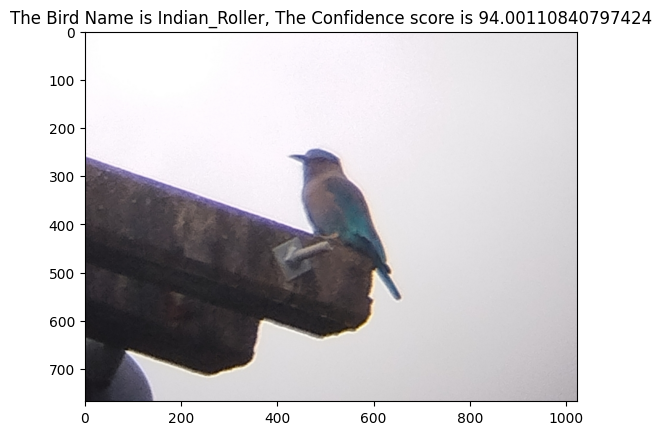

In [16]:
prediction_path = "/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/test/Indian_Roller/Indian_Roller_1282.jpg"
prediction(Bird_prediction, prediction_path)